# Problem Set 1: Edges and Lines
---
## Setup

In [1]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (14.0, 6.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

---
## 1. Edge Operator

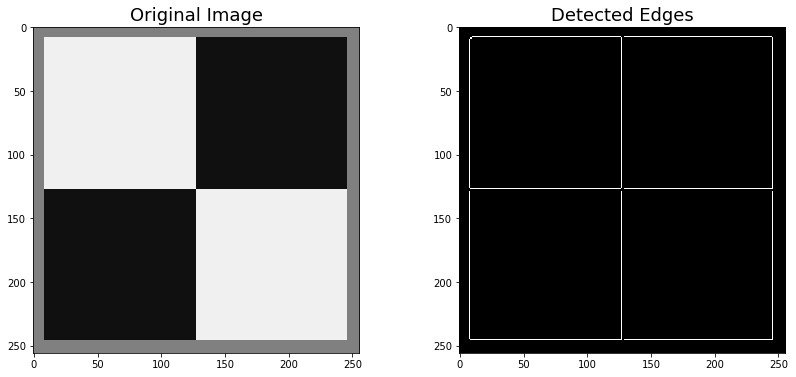

In [7]:
# Load image
img = cv2.imread('ps1-input0.png')
# OpenCV BGR to RGB
img = img[:,:,::-1]
# Edge Detection
edges = cv2.Canny(img, 100, 200)
# Plot
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_title('Original Image')
ax[0].imshow(img)
ax[1].set_title('Detected Edges')
ax[1].imshow(edges)

---
## 2. Hough Line Detector